In [1]:
!pip install pytorchvideo

from IPython import display
display.clear_output()

In [2]:
#-- Import Libraries -------------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.video import mvit_v2_s
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torch.autograd import Function
from PIL import Image
import numpy as np
from torchvision import transforms
import os
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
import math
#---------------------------------------------------------------------------------------------------------

In [3]:
#-- Initialize -----------------------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

NUM_CLASSES = 2
CLASS_NAMES = ['normal', 'fight']

NUM_FRAMES = 16
FRAME_W = 224
FRAME_H = 224
#---------------------------------------------------------------------------------------------------------

device: cpu


In [4]:
#-- Model Definition --------------------------------------------------------------------------------------
class VideoMViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super(VideoMViTModel, self).__init__()
        self.model = mvit_v2_s(weights="DEFAULT")
        self.model.head = nn.Linear(768, num_classes)

    def forward(self, x):
        return self.model(x)
#---------------------------------------------------------------------------------------------------------

In [5]:
#-- Load Model -----------------------------------------------------------------------------------------------
best_weights_dir = "/kaggle/input/fight-wholedata-fold4-60epoch/best_model_fold_4.pth"

model = VideoMViTModel(num_classes=2)  
checkpoint = torch.load(best_weights_dir, map_location=torch.device(DEVICE))
checkpoint = {k.replace('module.', ''): v for k, v in checkpoint.items()}


model.load_state_dict(checkpoint, strict=False)
model.eval()

print(':)')
#---------------------------------------------------------------------------------------------------------

Downloading: "https://download.pytorch.org/models/mvit_v2_s-ae3be167.pth" to /root/.cache/torch/hub/checkpoints/mvit_v2_s-ae3be167.pth
100%|██████████| 132M/132M [00:01<00:00, 70.5MB/s] 
<ipython-input-5-db7d62edd106>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loade

:)


In [7]:
#-- Function to Preprocess videos -------------------------------------------------------------------------------
def preprocess_video(video_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):    

    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, resize)
        frames.append(frame)

    cap.release()
    frames = np.array(frames, dtype=np.float32)  

    
    if len(frames) > num_frames:
        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        sampled_frames = frames[indices]
    elif len(frames) < num_frames:
        padding = np.zeros((num_frames - len(frames), *resize, 3), dtype=np.float32)
        sampled_frames = np.concatenate((frames, padding), axis=0)
    else:
        sampled_frames = frames

    
    sampled_frames = sampled_frames / 255.0  #-- Normalize
    sampled_frames = np.transpose(sampled_frames, (3, 0, 1, 2))  #-- (C, T, H, W)
    sampled_frames = torch.from_numpy(sampled_frames).unsqueeze(0)  #-- (1, C, T, H, W)

    return sampled_frames
#-------------------------------------------------------------------------------------------------------------

In [9]:
#-- function to Predict video label ------------------------------------------------------------------------------
def predict_video(model, video_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    
    preprocessed_video = preprocess_video(video_path,
                                          NUM_FRAMES,
                                          (FRAME_W, FRAME_H))    
   
    #-- Predict label --
    with torch.no_grad():
        outputs = model(preprocessed_video)
        _, predicted = torch.max(outputs, 1)  
    
    return predicted.item()
#-------------------------------------------------------------------------------------------------------------

In [10]:
#-- Hook function to get the features from the desired layer -----------------------------------------------
def save_features_hook(module, input, output):
    global features
    
    if isinstance(output, tuple):
        features = output[0] 
    else:
        features = output
#-------------------------------------------------------------------------------------------------------------

In [11]:
#-- Hook function to get the gradients of the output with respect to the chosen layer ---------------------
def save_grads_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0]
#-------------------------------------------------------------------------------------------------------------

In [12]:
#-------------------------------------------------------------------------------------------------------------
def apply_gradcam(model, video_tensor, target_layer):
    global features, grads

    #-- Register hooks --
    target_layer.register_forward_hook(save_features_hook)
    target_layer.register_backward_hook(save_grads_hook)

    #-- Forward pass --
    output = model(video_tensor)
    
    #-- Initialize a list to store Grad-CAM for each frame --
    gradcam_outputs = []

    #-- Iterate over each frame --
    for frame_idx in range(video_tensor.shape[2]):
        
        frame_tensor = video_tensor[:, :, frame_idx, :, :]  
        
        model.zero_grad()
        
        #-- Backward pass (with the target class) --
        target_class = torch.argmax(output, dim=1)
        output[0, target_class].backward(retain_graph=True)        

        #-- Ensure grads and features have compatible dimensions --
        grads = grads.detach()  #-- Detach to avoid any further computation
        features = features.detach()

        #-- Check if grads and features are 4D tensors, otherwise adjust --
        if len(grads.shape) == 4:
            grads = grads.squeeze(0)  #-- Remove batch dimension if present
        
        #-- If grads are 3D, mean pooling may need to be adjusted --
        if len(grads.shape) == 3:
            grads = grads.unsqueeze(2).unsqueeze(3)  #-- Add height and width dimensions for global pooling

        #-- Global average pooling --
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)  # Global average over spatial dimensions (height, width)

        #-- Weighted sum of feature maps --
        cam = torch.sum(weights * features, dim=1, keepdim=True)

        #-- ReLU activation --
        cam = F.relu(cam)

        #-- Normalize the CAM --        
        if torch.max(cam) != 0:
            cam = cam / torch.max(cam)
        else:
            cam = torch.zeros_like(cam)

        #-- Store Grad-CAM for the current frame --
        gradcam_outputs.append(cam.squeeze().cpu().numpy())
    
    return np.array(gradcam_outputs)
#-------------------------------------------------------------------------------------------------------------

In [18]:
#-------------------------------------------------------------------------------------------------------------
def visualize_gradcam_per_frame(video_tensor, gradcam_output, resize=(FRAME_W, FRAME_H)):
    
    heatmap_images = []    
    gradcam_output_resized = np.zeros((gradcam_output.shape[0], resize[0], resize[1], 3))  
   
    for i in range(gradcam_output.shape[0]):        
        gradcam_map = cv2.resize(gradcam_output[i], (resize[1], resize[0])) 
        gradcam_map = np.uint8(255 * gradcam_map)  
        gradcam_map = cv2.cvtColor(gradcam_map, cv2.COLOR_GRAY2BGR)  
        gradcam_output_resized[i] = gradcam_map

    
    video_tensor = video_tensor.squeeze(0).cpu().numpy()     
    video_tensor =  np.transpose(video_tensor, (1, 2, 3, 0))    
    
    for frame_idx in range(video_tensor.shape[0]):        
        frame = video_tensor[frame_idx]
        frame = np.uint8(255 * frame)          
        
        frame_resized = cv2.resize(frame, (resize[1], resize[0]))  # Resize frame to match Grad-CAM        
       
        current_gradcam_output_resized = gradcam_output_resized[frame_idx]        
       
        current_gradcam_output_resized = np.uint8(current_gradcam_output_resized)
        
        heatmap = cv2.applyColorMap(current_gradcam_output_resized, cv2.COLORMAP_JET)       
        
        combined = cv2.addWeighted(frame_resized, 0.6, heatmap, 0.4, 0)        
        
        heatmap_images.append(combined)
    
    return heatmap_images
#-------------------------------------------------------------------------------------------------------------

In [17]:
#-------------------------------------------------------------------------------------------------------------
def show_top_gradcam_frames(video_tensor, gradcam_output, top_k=5, max_cols=3):
    
    attention_scores = gradcam_output.mean(axis=(1, 2))      
    top_indices = np.argsort(attention_scores)[-top_k:][::-1]     
    video_np = video_tensor.squeeze().permute(1, 2, 3, 0).cpu().numpy()  
    
    cols = min(top_k, max_cols)
    rows = math.ceil(top_k / cols)

    plt.figure(figsize=(3 * cols, 3 * rows))
    for i, idx in enumerate(top_indices):
        frame = video_np[idx]
        heatmap = gradcam_output[idx]
        heatmap_resized = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized / (heatmap_resized.max() + 1e-6))
        heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

        frame_uint8 = np.uint8(255 * frame)
        frame_bgr = cv2.cvtColor(frame_uint8, cv2.COLOR_RGB2BGR)
        overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap_color, 0.4, 0)
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(overlay_rgb)
        plt.title(f"Frame {idx}\nScore: {attention_scores[idx]:.3f}")
        plt.axis('off')

    plt.suptitle("Top Attention Frames by Grad-CAM", fontsize=16)
    plt.tight_layout()
    plt.show()
#-------------------------------------------------------------------------------------------------------------

In [15]:
#-------------------------------------------------------------------------------------------------------------
target_layer = model.model.blocks[-2].attn
#-------------------------------------------------------------------------------------------------------------

Predicted label: fight


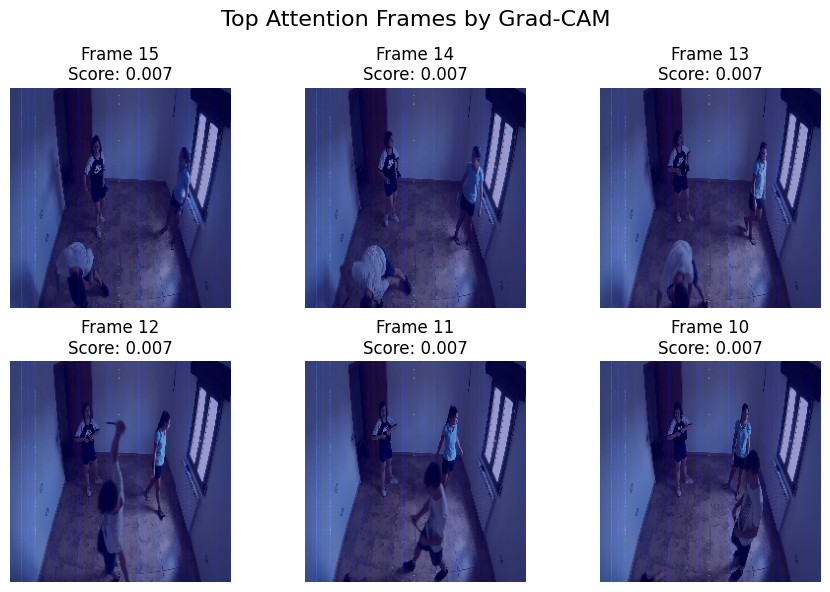

In [20]:
#-------------------------------------------------------------------------------------------------------------
video_path = '/kaggle/input/sample-videos-for-fight-detection-2/fight/fight (12).mp4'

#-- Predict the label of the video --
predicted_label = predict_video(model, video_path)
print(f'Predicted label: {CLASS_NAMES[predicted_label]}')
print('===========================================================')

video_tensor = preprocess_video(video_path,
                                NUM_FRAMES,
                                (FRAME_W, FRAME_H))
gradcam_output = apply_gradcam(model, video_tensor, target_layer)

# plt.imshow(gradcam_output[0], cmap='jet')
# plt.colorbar()
# plt.title("Grad-CAM Map for First Frame")
# plt.show()

# print('video_tensor:', video_tensor.shape)
# print('gradcam_output:', gradcam_output.shape)
# print('===========================================================')


# Visualize Grad-CAM per frame
gradcam_images = visualize_gradcam_per_frame(video_tensor, gradcam_output)
# print('===========================================================')


# Show top frames with highest Grad-CAM activation
show_top_gradcam_frames(video_tensor, gradcam_output, top_k=6)
#-------------------------------------------------------------------------------------------------------------